# Hazardous Near-Earth Object Classification
This project was developed as part of the Stanford Pre-Collegiate Summer Institutes.
It applies machine learning models to predict whether near-Earth objects (NEOs) are hazardous based on NASA data.

Key metric: **Maximizing recall** to avoid missing hazardous objects.

## 1. Imports

In [16]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt 
import seaborn as sns

## 2. Data Cleaning and Feature Engineering 

In [17]:
data = pd.read_csv("neo.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [18]:
# Check for null values
data.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [19]:
# Check number of unique values
data.nunique()

id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64

In [20]:
# Drop redundant columns
data = data.drop(['id','orbiting_body','name','sentry_object'],axis = 'columns')

In [21]:
# Encode 'sentry_object' as binary (True → 1, False → 0)
data['hazardous'] = data['hazardous'].astype(int)

In [22]:
# Reduce number of decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   est_diameter_min    90836 non-null  float64
 1   est_diameter_max    90836 non-null  float64
 2   relative_velocity   90836 non-null  float64
 3   miss_distance       90836 non-null  float64
 4   absolute_magnitude  90836 non-null  float64
 5   hazardous           90836 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 4.2 MB


In [23]:
# Summary of statistics
print("\nSummary of statistics: \n", data.describe().T)


Summary of statistics: 
                       count        mean         std     min         25%  \
est_diameter_min   90836.00        0.13        0.30    0.00        0.02   
est_diameter_max   90836.00        0.28        0.67    0.00        0.04   
relative_velocity  90836.00    48066.92    25293.30  203.35    28619.02   
miss_distance      90836.00 37066546.03 22352040.60 6745.53 17210820.24   
absolute_magnitude 90836.00       23.53        2.89    9.23       21.34   
hazardous          90836.00        0.10        0.30    0.00        0.00   

                           50%         75%         max  
est_diameter_min          0.05        0.14       37.89  
est_diameter_max          0.11        0.32       84.73  
relative_velocity     44190.12    62923.60   236990.13  
miss_distance      37846579.26 56548996.45 74798651.45  
absolute_magnitude       23.70       25.70       33.20  
hazardous                 0.00        0.00        1.00  


In [24]:
# Log-transform skewed features
log_cols = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance']
data[log_cols] = data[log_cols].apply(np.log1p)

In [25]:
# Print updated stats
print("\nSummary of statistics AFTER log transform:\n", data.describe().T)
print(data['hazardous'].value_counts(normalize=True))


Summary of statistics AFTER log transform:
                       count  mean  std  min   25%   50%   75%   max
est_diameter_min   90836.00  0.11 0.15 0.00  0.02  0.05  0.13  3.66
est_diameter_max   90836.00  0.21 0.26 0.00  0.04  0.10  0.28  4.45
relative_velocity  90836.00 10.63 0.58 5.32 10.26 10.70 11.05 12.38
miss_distance      90836.00 17.05 1.14 8.82 16.66 17.45 17.85 18.13
absolute_magnitude 90836.00 23.53 2.89 9.23 21.34 23.70 25.70 33.20
hazardous          90836.00  0.10 0.30 0.00  0.00  0.00  0.00  1.00
hazardous
0   0.90
1   0.10
Name: proportion, dtype: float64


In [26]:
 # Pearson's correlation
print("\nPearson's correlation: \n ",data.corr())


Pearson's correlation: 
                      est_diameter_min  est_diameter_max  relative_velocity  \
est_diameter_min                1.00              0.99               0.28   
est_diameter_max                0.99              1.00               0.29   
relative_velocity               0.28              0.29               1.00   
miss_distance                   0.23              0.25               0.22   
absolute_magnitude             -0.80             -0.85              -0.31   
hazardous                       0.29              0.32               0.18   

                    miss_distance  absolute_magnitude  hazardous  
est_diameter_min             0.23               -0.80       0.29  
est_diameter_max             0.25               -0.85       0.32  
relative_velocity            0.22               -0.31       0.18  
miss_distance                1.00               -0.34       0.07  
absolute_magnitude          -0.34                1.00      -0.37  
hazardous                    0.

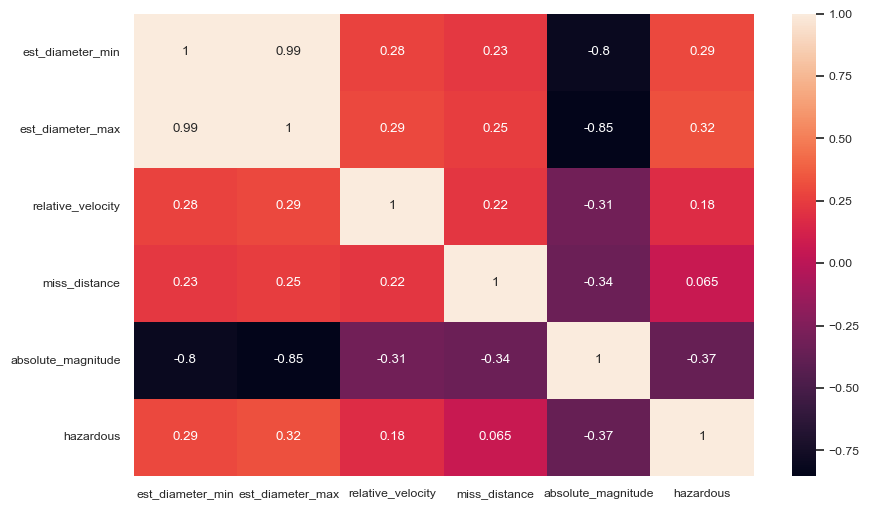

In [28]:
# Pearson's correlation (with heatmap)
plt.figure(figsize=(10,6))
sns.set(font_scale=0.8)
plt.rcParams["axes.labelsize"] = 0.5
sns.heatmap(data.corr(), annot=True);

In [35]:
# Combine est_diameter_min and est_diameter_max into a single average diameter
# Reason: Pearson correlation analysis showed a near-perfect correlation (0.99) between them,
# meaning they are redundant. Combining them reduces multicollinearity and simplifies the model
data['est_diameter_avg'] = (data['est_diameter_min'] + data['est_diameter_max']) / 2
data.drop(columns=['est_diameter_min', 'est_diameter_max'], inplace=True)

## 3. Data Analysis

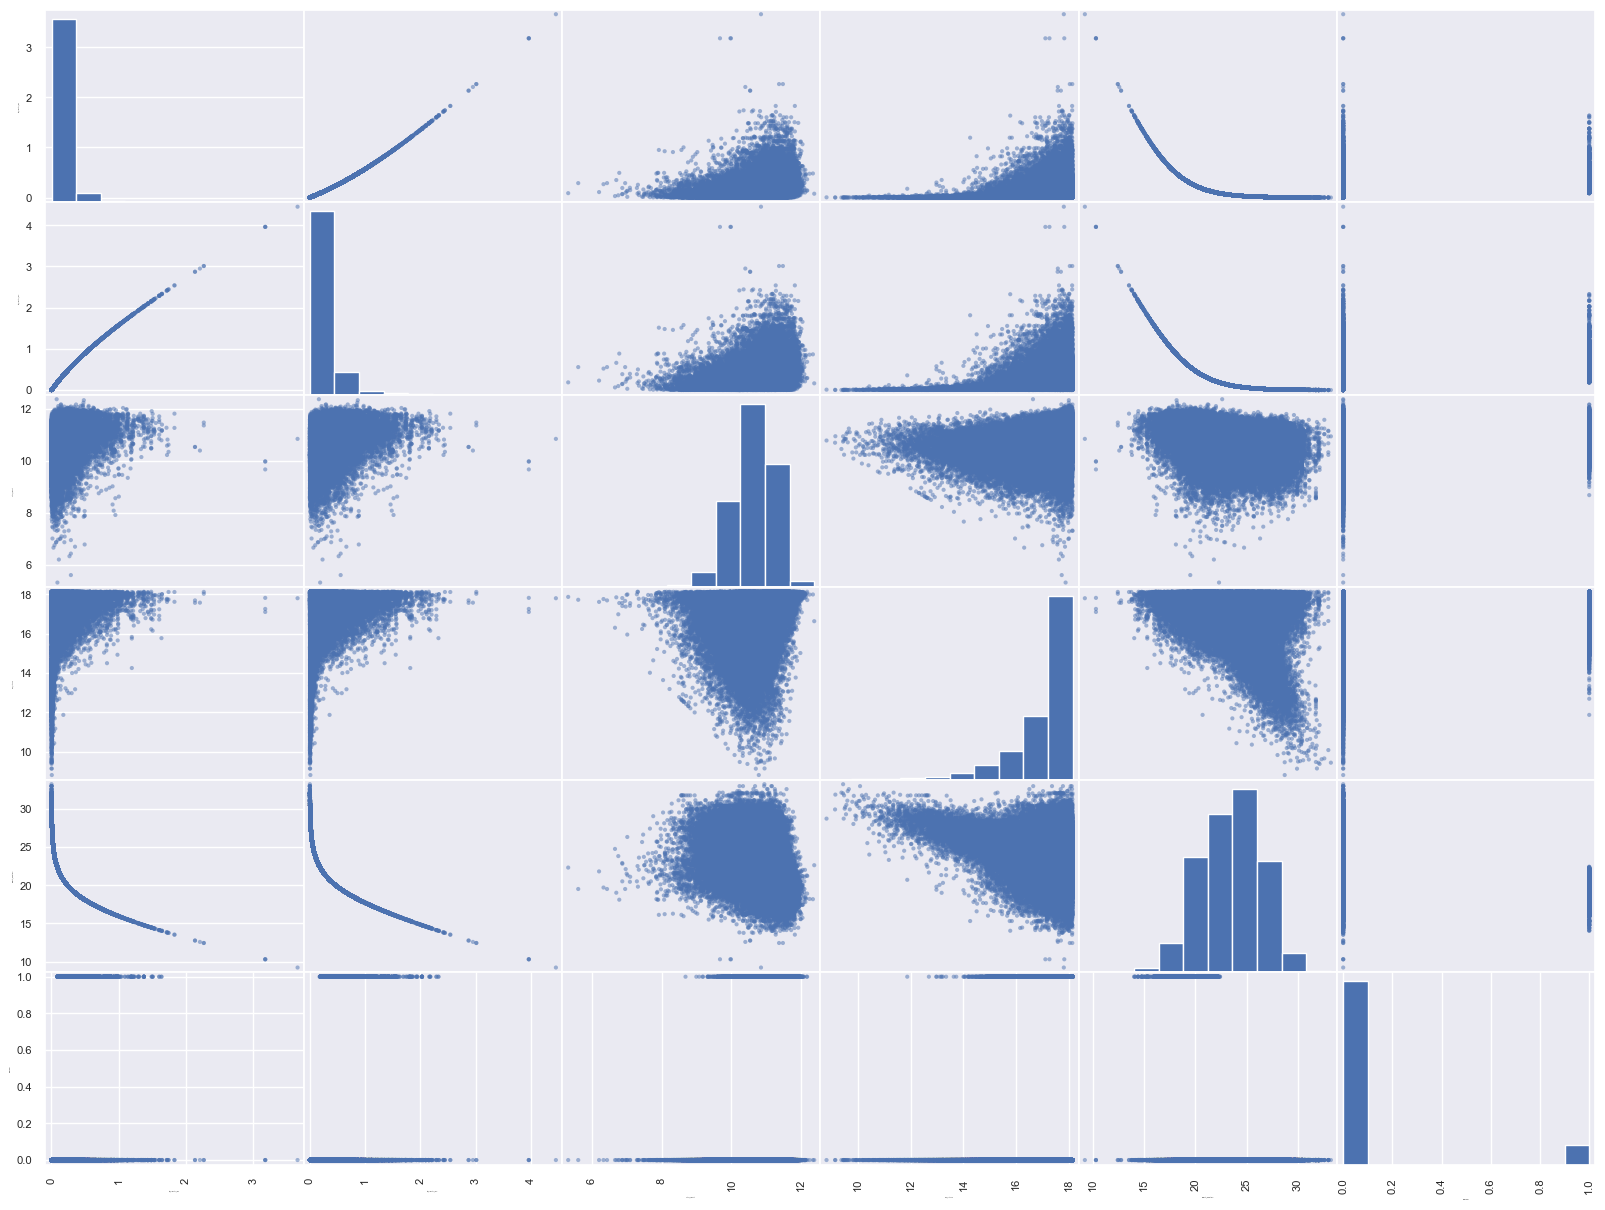

In [29]:
pd.plotting.scatter_matrix(data,figsize=(20,15))
plt.show()

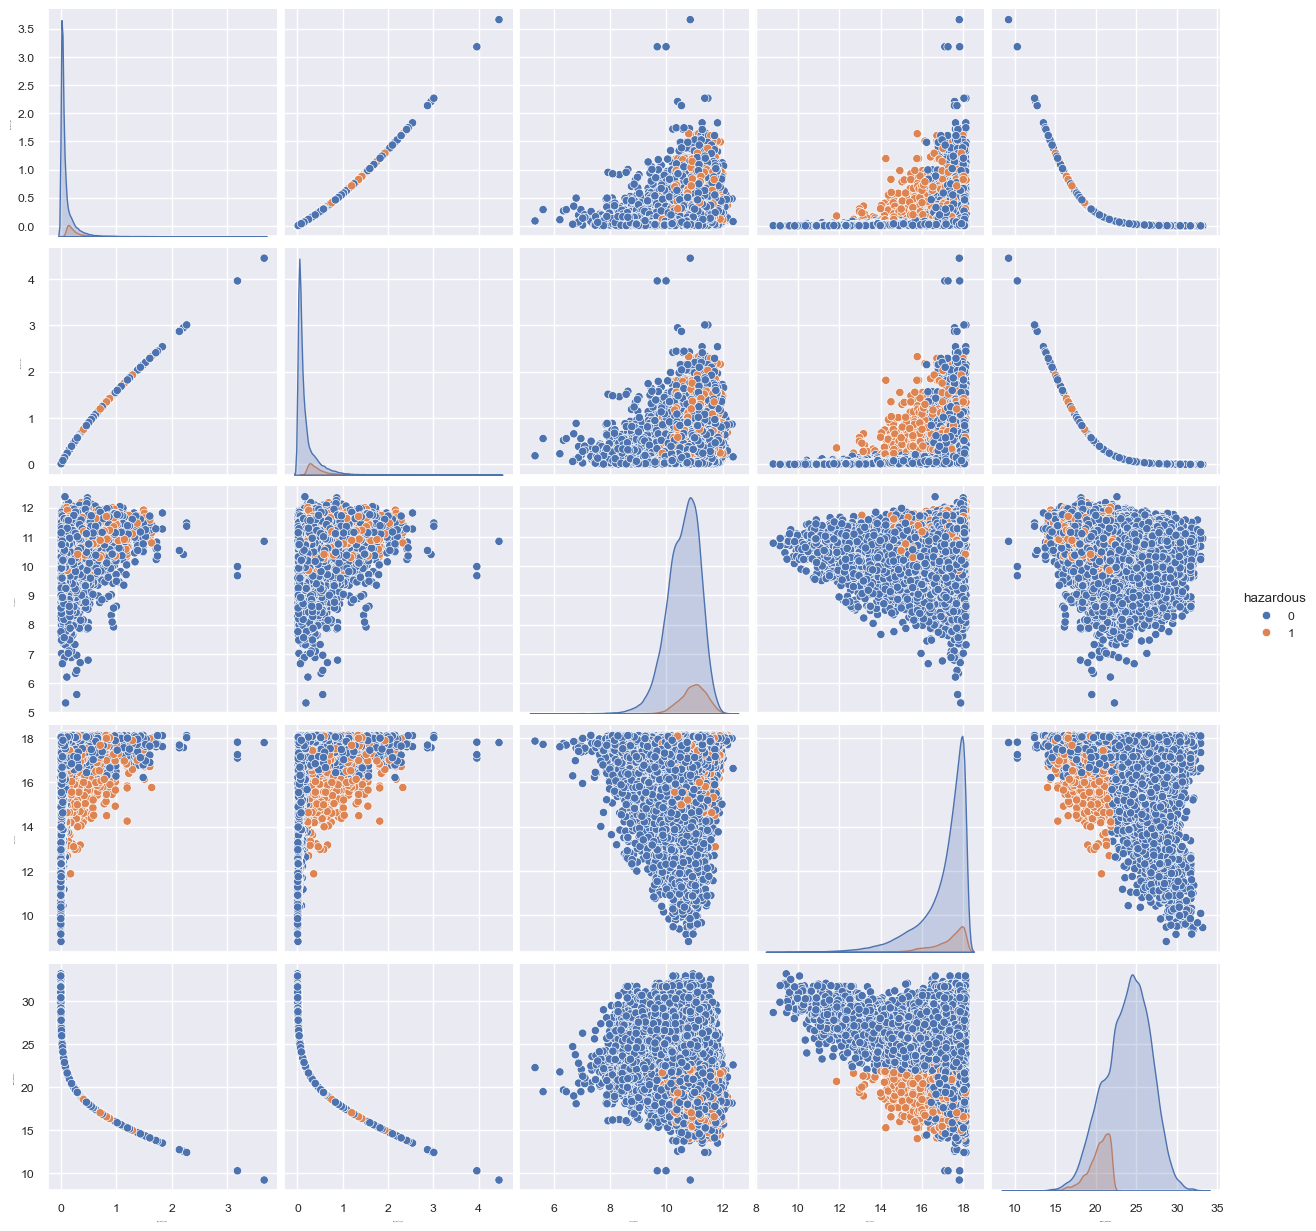

In [30]:
sns.pairplot(data,hue="hazardous");

### Scatter Matrix of Features

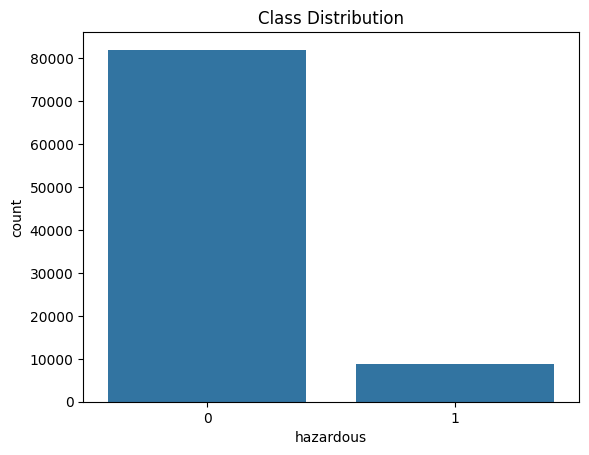

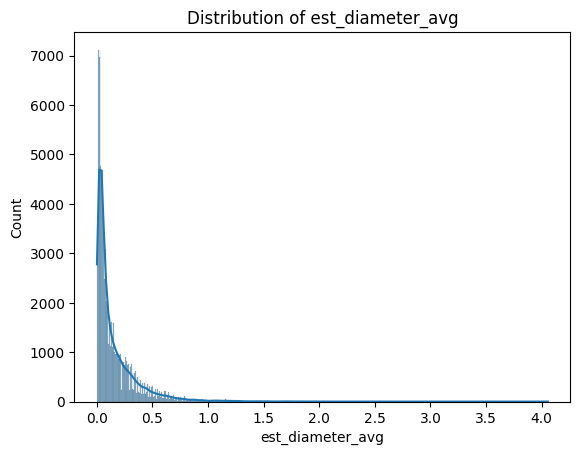

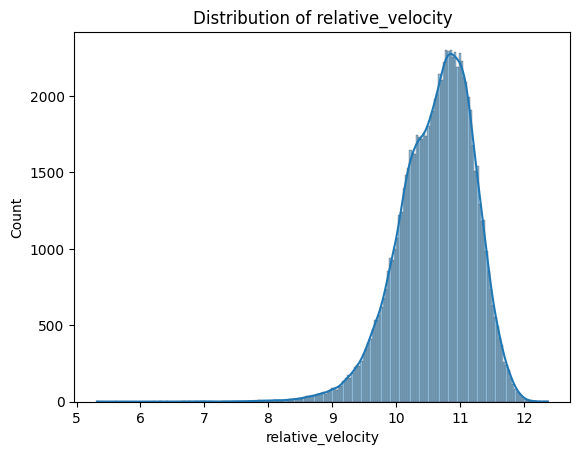

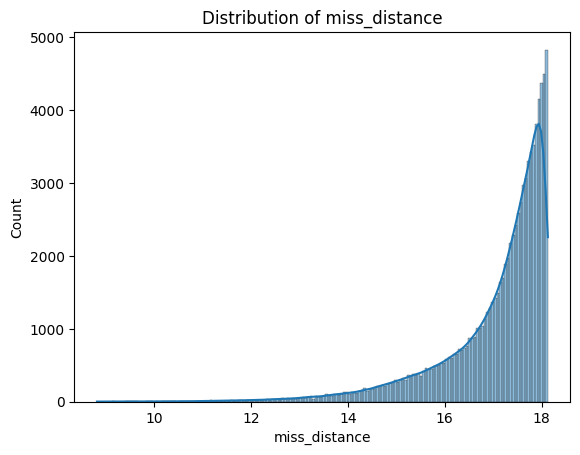

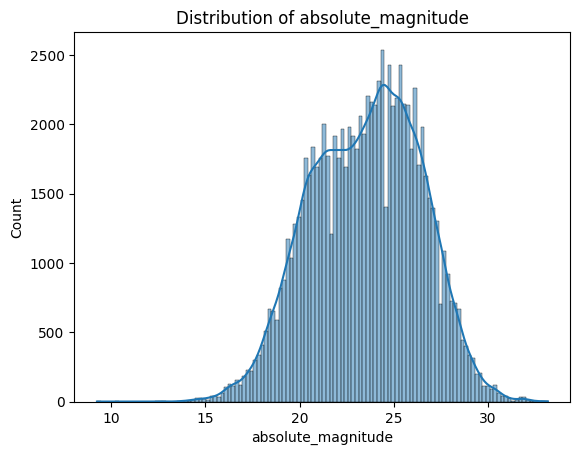

In [ ]:
pd.plotting.scatter_matrix(data, figsize=(20, 15), diagonal='kde')
plt.suptitle("Scatter Matrix of Features", fontsize=16)
plt.show()

- A strong inverse relationship between absolute_magnitude and est_diameter_avg, indicating that brighter objects tend to be larger.
- Hazardous objects (class 1) generally have larger diameters and lower magnitudes.
- Miss distance shows weak separability, suggesting limited predictive value.
- Relative velocity is tightly clustered but may help distinguish hazardous cases at higher extremes.

### Univariate Analysis

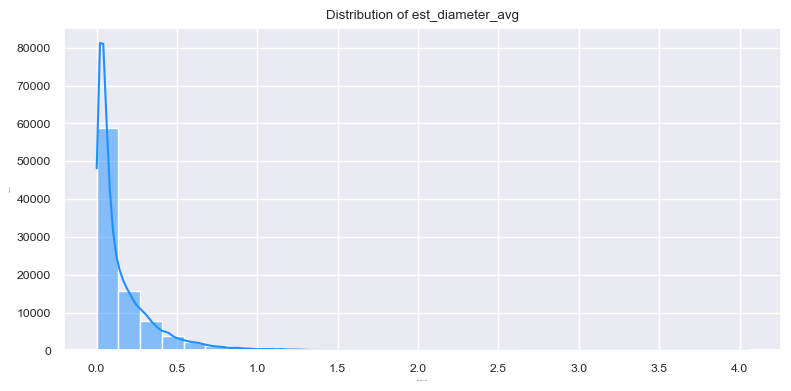

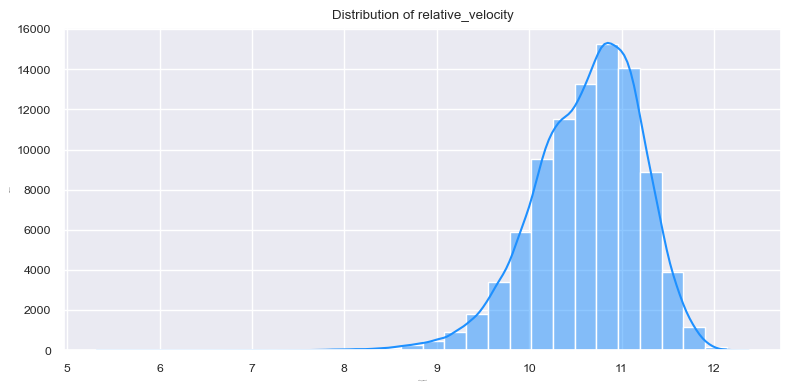

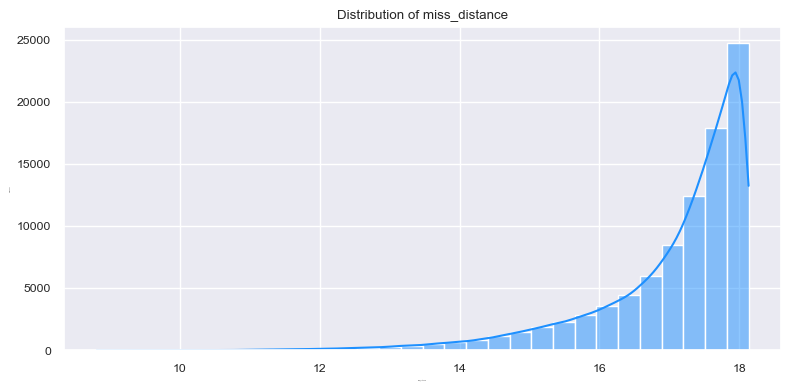

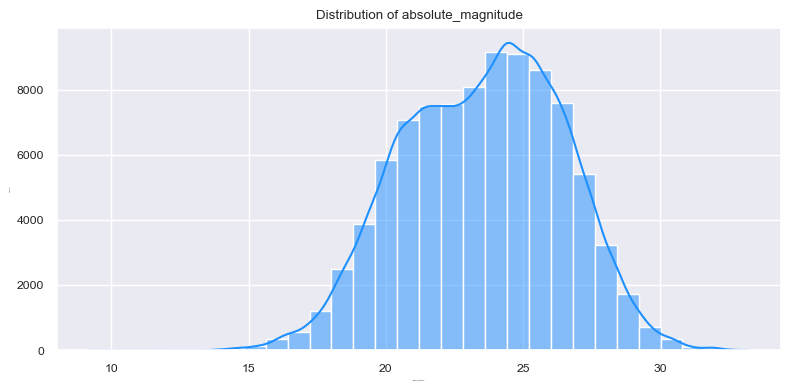

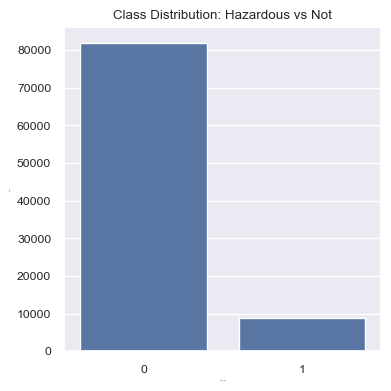

In [37]:
num_features = ['est_diameter_avg', 'relative_velocity', 'miss_distance', 'absolute_magnitude']

for feature in num_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True, bins=30, color='dodgerblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Target variable (hazardous)
plt.figure(figsize=(4, 4))
sns.countplot(x='hazardous', data=data)
plt.title("Class Distribution: Hazardous vs Not")
plt.xlabel("Hazardous")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

- est_diameter_avg: Right-skewed with most values near zero; log transform helped normalize its scale.
- relative_velocity: Nearly symmetric, unimodal distribution centered around 10.5; minimal transformation needed.
- miss_distance: Strongly right-skewed; most NEOs are far from Earth, but lower outliers may be key for hazard detection.
- absolute_magnitude: Bell-shaped and well-distributed; no transformation necessary. Lower values (brighter objects) may correlate with hazard.


### Bivariate Analysis

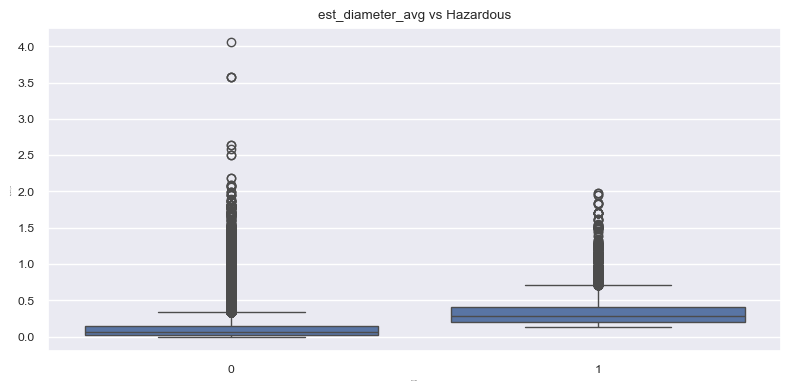

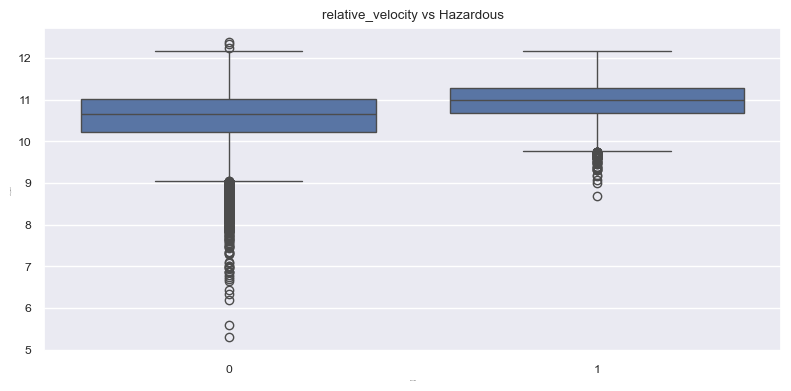

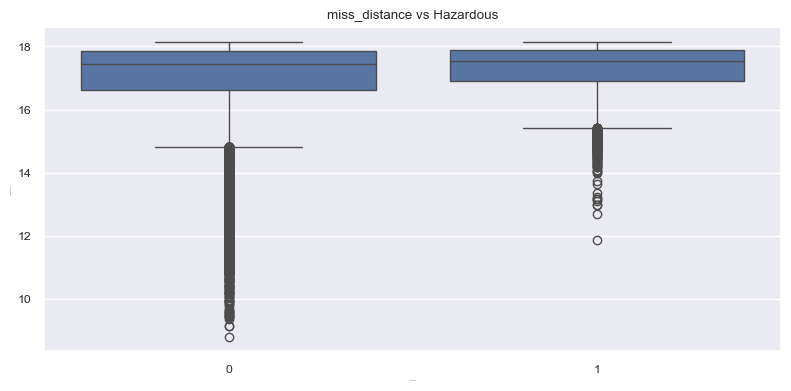

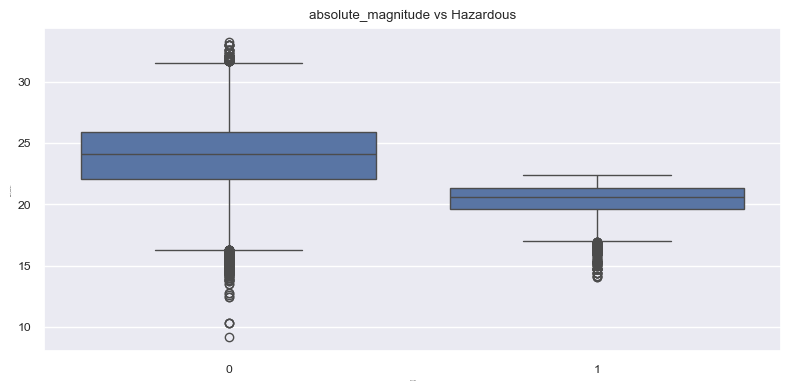

In [39]:
features = ['est_diameter_avg', 'relative_velocity', 'miss_distance', 'absolute_magnitude']

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='hazardous', y=feature, data=data)
    plt.title(f'{feature} vs Hazardous')
    plt.xlabel('Hazardous')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


### Key Insights:

- Hazardous NEOs tend to have larger average diameters than non-hazardous ones. The median value is noticeably higher, supporting the intuition that larger objects pose greater risks.
- While both classes show a similar velocity range, hazardous objects slightly lean toward higher relative velocities. However, the separation is not as strong as with other features.
- Non-hazardous objects typically have larger miss distances. Hazardous objects cluster toward closer encounters with Earth, which aligns with their classification. This feature provides strong discriminatory power.
- Hazardous objects generally have lower magnitudes (i.e., they are brighter). This is consistent with their larger sizes. The distinction here is quite sharp, suggesting good predictive potential.

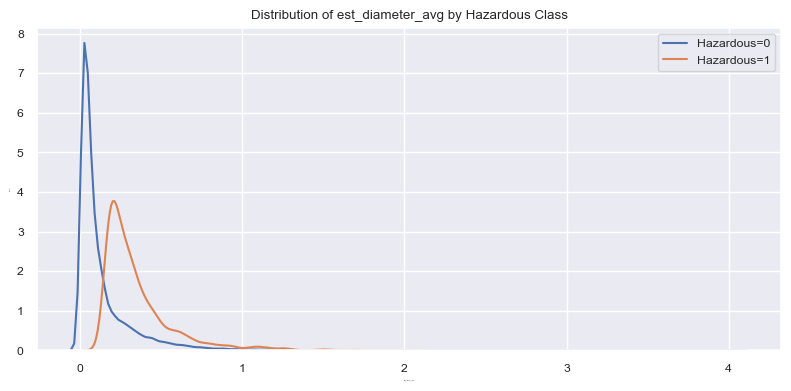

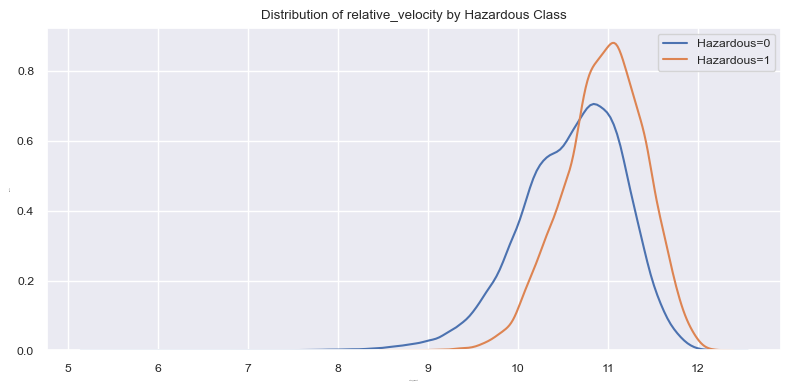

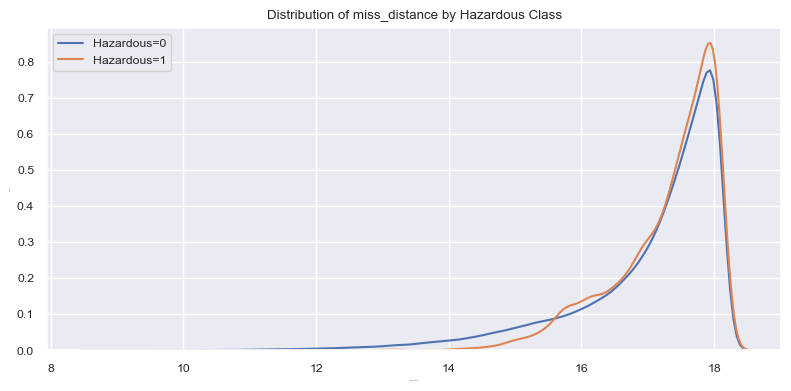

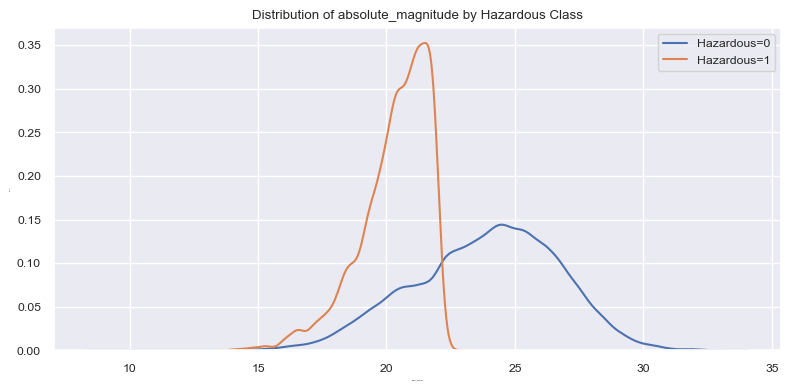

In [40]:
for feature in features:
    plt.figure(figsize=(8, 4))
    for cls in [0, 1]:
        subset = data[data['hazardous'] == cls]
        sns.kdeplot(subset[feature], label=f"Hazardous={cls}")
    plt.title(f'Distribution of {feature} by Hazardous Class')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


### Key Insights:

- Hazardous NEOs tend to have larger diameters than non-hazardous ones. The distribution for hazardous asteroids is slightly right-shifted, with more high-diameter outliers.
- Hazardous objects show a slight increase in relative velocity compared to non-hazardous ones. However, the overlap between classes suggests it is only a weak predictor on its own.
- As expected, hazardous NEOs generally have a smaller miss distance (closer approaches). The distributions are similar, but hazardous NEOs cluster more in the lower tail.
- Hazardous NEOs tend to have lower magnitude (i.e., they are brighter), often correlating with larger size. This feature shows a stronger separation between the two classes, making it a useful signal.

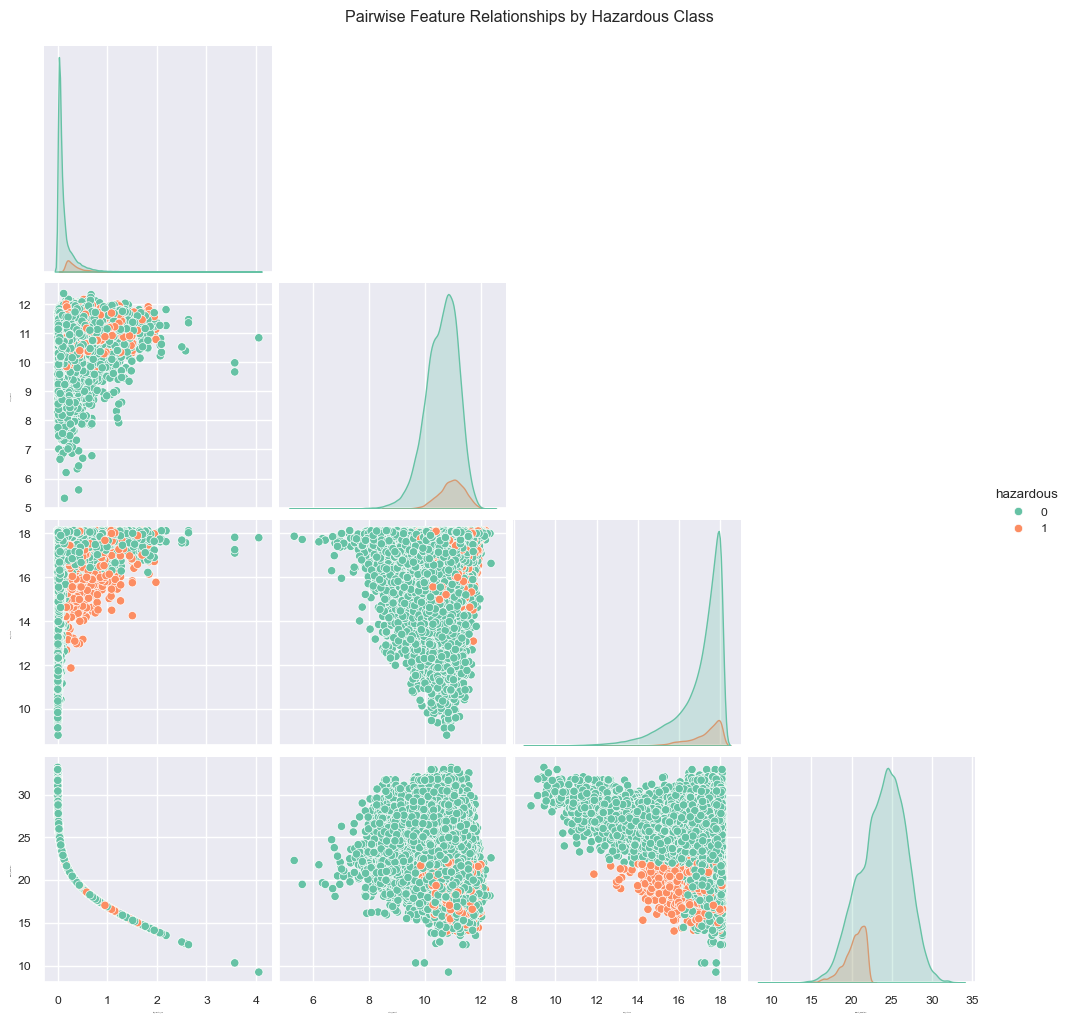

In [41]:
sns.pairplot(data[features + ['hazardous']], hue='hazardous', palette='Set2', corner=True)
plt.suptitle('Pairwise Feature Relationships by Hazardous Class', y=1.02)
plt.show()


## 4. Create Features / Target Variables 

In [43]:
X = data.drop(columns=["hazardous"])
y = data["hazardous"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [48]:
# Since the dataset is imbalanced, with significantly fewer hazardous examples, I apply SMOTE (Synthetic Minority Over-sampling Technique) 
# to balance the classes in the training set. This helps the model learn patterns from both classes more effectively.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [49]:
# Check the new class balance
print("Original training distribution:\n", y_train.value_counts())
print("Resampled training distribution:\n", y_train_resampled.value_counts())

Original training distribution:
 hazardous
0    61497
1     6630
Name: count, dtype: int64
Resampled training distribution:
 hazardous
0    61497
1    61497
Name: count, dtype: int64


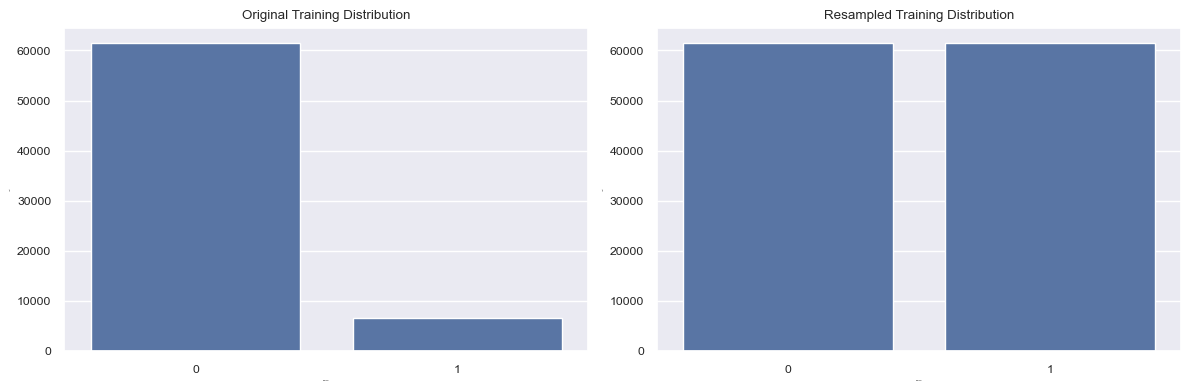

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title("Original Training Distribution")

sns.countplot(x=y_train_resampled, ax=axs[1])
axs[1].set_title("Resampled Training Distribution")

plt.tight_layout()
plt.show()

## 5. Hyperparemeter Tuning 

In [54]:
# Scale the features (especially for KNN, Logistic Regression, and SVM)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [58]:
# Use stratified folds to maintain class balance across splits
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [59]:
# Define hyperparameter grids
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ["l1", "l2"],
            "solver": ["liblinear"],  # only liblinear supports L1
            "class_weight": ["balanced", None]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "class_weight": ["balanced"]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": list(range(3, 16, 2)),
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "SVM": {
        "model": LogisticRegression(),  # swap to SVC if using SVM kernel
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["liblinear"],  # use SVC(kernel='linear') for true SVM
            "class_weight": ["balanced"]
        }
    }
}

In [60]:
# Perform grid search for each model
from sklearn.model_selection import GridSearchCV

best_models = {}

for name, mp in param_grids.items():
    print(f"Tuning {name}...")
    
    grid = GridSearchCV(mp["model"], mp["params"], cv=cv, scoring="recall", n_jobs=-1)
    
    if name == "Random Forest":
        grid.fit(X_train_resampled, y_train_resampled)
    else:
        grid.fit(X_train_scaled, y_train_resampled)

    best_models[name] = grid.best_estimator_
    print(f"Best parameters for {name}:\n", grid.best_params_)

Tuning Logistic Regression...


/Users/katerynakolomiichenko/Desktop/Personal/Summer 2025/ML/Nearest Earth Objects/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynakolomiichenko/Desktop/Personal/Summer 2025/ML/Nearest Earth Objects/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynakolomiichenko/Desktop/Personal/Summer 2025/ML/Nearest Earth Objects/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynakolomiichenko/Desktop/Personal/Summer 2025/ML/Nearest Earth Objects/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kater

Best parameters for Logistic Regression:
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Tuning Random Forest...
Best parameters for Random Forest:
 {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Tuning KNN...
Best parameters for KNN:
 {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Tuning SVM...
Best parameters for SVM:
 {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}



Logistic Regression Performance:


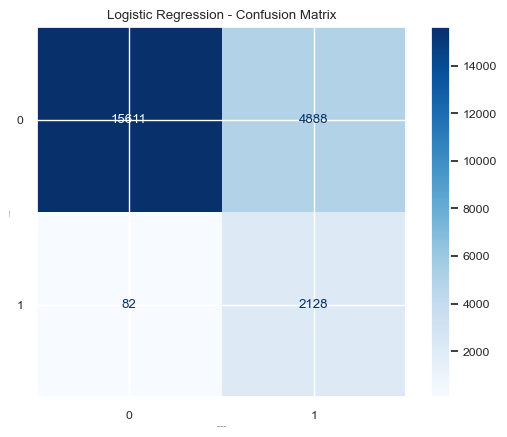

              precision    recall  f1-score   support

           0     0.9948    0.7615    0.8627     20499
           1     0.3033    0.9629    0.4613      2210

    accuracy                         0.7811     22709
   macro avg     0.6490    0.8622    0.6620     22709
weighted avg     0.9275    0.7811    0.8236     22709


Random Forest Performance:


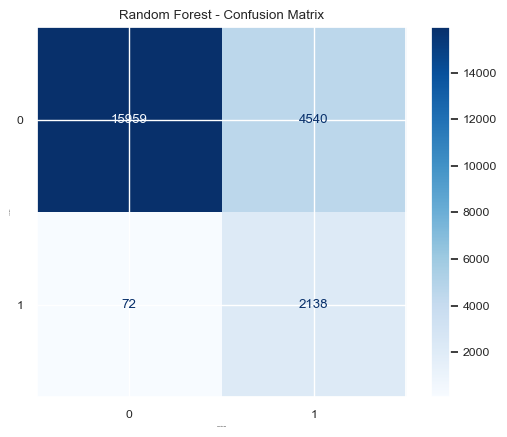

              precision    recall  f1-score   support

           0     0.9955    0.7785    0.8737     20499
           1     0.3202    0.9674    0.4811      2210

    accuracy                         0.7969     22709
   macro avg     0.6578    0.8730    0.6774     22709
weighted avg     0.9298    0.7969    0.8355     22709


KNN Performance:


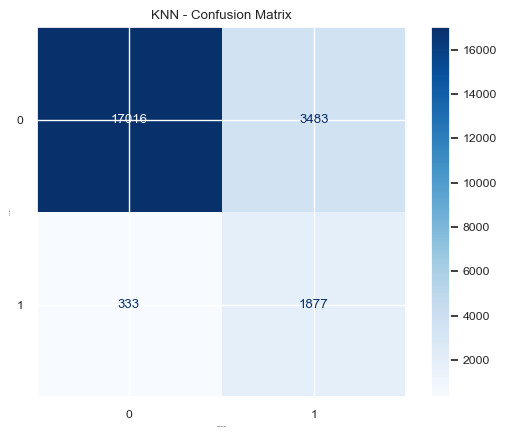

              precision    recall  f1-score   support

           0     0.9808    0.8301    0.8992     20499
           1     0.3502    0.8493    0.4959      2210

    accuracy                         0.8320     22709
   macro avg     0.6655    0.8397    0.6975     22709
weighted avg     0.9194    0.8320    0.8599     22709


SVM Performance:


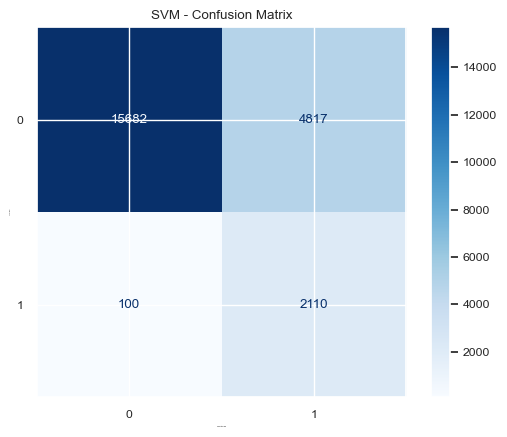

              precision    recall  f1-score   support

           0     0.9937    0.7650    0.8645     20499
           1     0.3046    0.9548    0.4619      2210

    accuracy                         0.7835     22709
   macro avg     0.6491    0.8599    0.6632     22709
weighted avg     0.9266    0.7835    0.8253     22709



In [65]:
# Collect performance metrics
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

metrics_summary = []

for name, model in best_models.items():
    print(f"\n{name} Performance:")
    
    if name == "Random Forest":
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test if name == "Random Forest" else X_test_scaled, y_test, cmap='Blues')
    disp.ax_.set_title(f"{name} - Confusion Matrix")
    plt.show()

    # Display classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Collect metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    metrics_summary.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })


In [66]:
# Display metrics summary as DataFrame
import pandas as pd

metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
display(metrics_df)

,Model,Precision,Recall,F1-Score
0,KNN,0.35,0.85,0.50
1,Random Forest,0.32,0.97,0.48
2,SVM,0.30,0.95,0.46
3,Logistic Regression,0.30,0.96,0.46


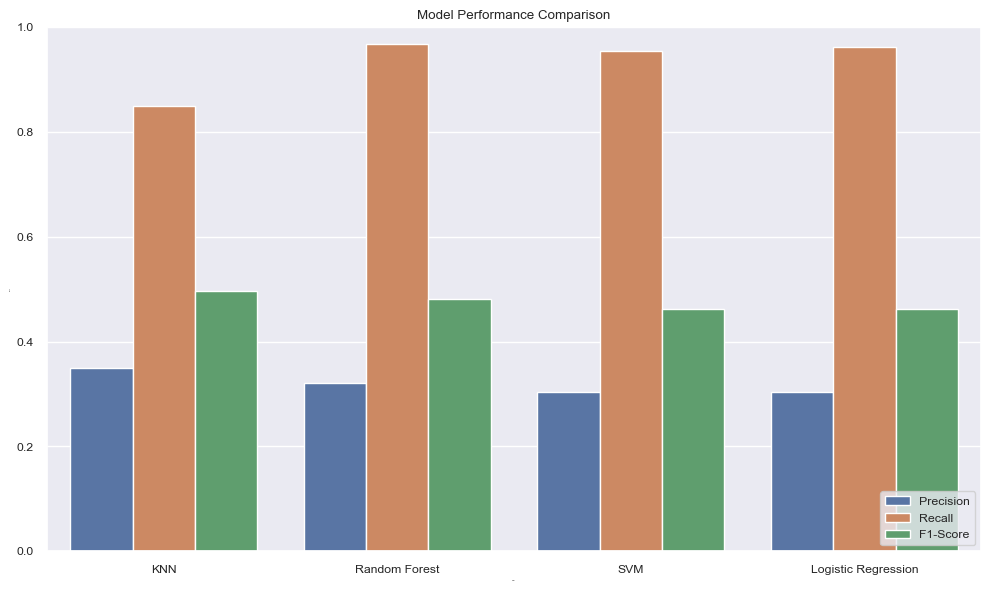

In [67]:

# Plot model comparison
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), 
            x="Model", y="Score", hue="Metric")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Analysis

After training, tuning, and evaluating four supervised machine learning models, **Logistic Regression**, **Random Forest**, **K-Nearest Neighbors (KNN)**, and **Support Vector Machine (SVM)**, I found that **KNN** achieved the **highest F1-Score (0.50)** among the tested classifiers.

- **Random Forest** and **SVM** showed strong recall values, suggesting good identification of hazardous objects, but their precision was relatively low, indicating a higher false positive rate.
- **Logistic Regression** delivered the most balanced performance overall, but lagged in precision and F1-score compared to KNN.

### Key Takeaways

- All models struggled with class imbalance, even after SMOTE oversampling. Further improvement might be achieved through advanced.
- Visual inspection of confusion matrices confirms the trade-off between precision and recall across different classifiers.
- **KNN** may be preferred for real-time systems prioritizing balanced accuracy, while **Random Forest** and **SVM** may be useful when recall is more critical (e.g., minimizing false negatives in planetary defense).